# Resource Recommendation Engine: Model Development

This notebook implements and tests the recommendation models for the Float Resource Recommendation Engine.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle

# Add src directory to path for imports
sys.path.append(os.path.abspath('..'))

from src.data.data_processor import DataProcessor
from src.models.collaborative_filtering import CollaborativeFilteringModel
from src.models.content_based_filtering import ContentBasedFilteringModel
from src.models.constraint_optimizer import ConstraintOptimizer
from src.models.recommendation_model import RecommendationEngine
from src.utils.evaluation import evaluate_recommendations, evaluate_skill_coverage
from src.visualization.visualize import plot_team_recommendation

# Set plotting style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline

## Load and Process Data

First, let's load and process the data for our recommendation models.

In [4]:
# Initialize data processor
processor = DataProcessor()

# Load raw data
raw_data = processor.load_data()

# Process data
processed_data = processor.process_data()

# Create feature matrices
feature_matrices = processor.create_feature_matrices()

# Create train/test split
train_test_split = processor.create_train_test_split(test_size=0.2, random_state=42)

# Prepare training and testing data
train_data = {}
test_data = {}

# Add processed datasets to train/test data
for name, split in train_test_split.items():
    train_data[name] = split['train']
    test_data[name] = split['test']
    
# Add feature matrices to train data
for name, matrix in feature_matrices.items():
    train_data[name] = matrix
    
print("Data loaded and processed successfully.")
print(f"Training data contains {len(train_data['projects'])} projects and {len(train_data['resources'])} resources.")
print(f"Testing data contains {len(test_data['projects'])} projects and {len(test_data['resources'])} resources.")

Loading data/raw/projects.csv...
Loading data/raw/allocations.csv...
Loading data/raw/feedback.csv...
Loading data/raw/resource_skills.csv...
Loading data/raw/resources.csv...
Data loaded and processed successfully.
Training data contains 40 projects and 24 resources.
Testing data contains 10 projects and 6 resources.


## Collaborative Filtering Model

Let's implement and test the collaborative filtering model first.

In [5]:
# Initialize and train collaborative filtering model
collab_model = CollaborativeFilteringModel()

# Train model
if 'project_resource_matrix' in train_data and 'project_success' in train_data:
    collab_model.train(
        train_data['project_resource_matrix'],
        train_data['project_success']
    )
    print("Collaborative filtering model trained successfully.")
else:
    print("Missing required data for collaborative filtering model.")

Collaborative filtering model trained successfully.


Recommendations for project Project 14:
resource_id
r10    1.000000
r7     0.939743
r21    0.853906
r20    0.815183
r4     0.784699
dtype: float64


/home/taiwo/resource-recommendation-engine/src/models/collaborative_filtering.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.44098509720241' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  resource_scores[resource_id] += weight * allocation


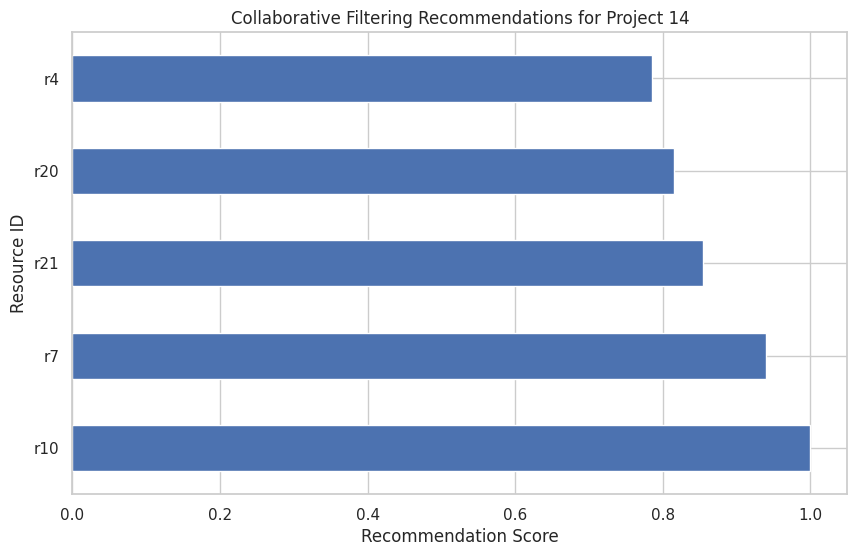

In [6]:
# Test collaborative filtering model on a sample project
if collab_model.is_trained:
    # Select a sample project from test data
    sample_project = test_data['projects'].iloc[0]
    
    # Create project requirements
    project_requirements = {
        'id': sample_project['id'],
        'name': sample_project['name']
    }
    
    # Get recommendations
    recommendations = collab_model.recommend_team(
        project_requirements,
        team_size=5,
        existing_team=[]
    )
    
    print(f"Recommendations for project {sample_project['name']}:")
    print(recommendations)
    
    # Plot recommendations
    plt.figure(figsize=(10, 6))
    recommendations.plot(kind='barh')
    plt.title(f'Collaborative Filtering Recommendations for {sample_project["name"]}')
    plt.xlabel('Recommendation Score')
    plt.ylabel('Resource ID')
    plt.show()

## Content-Based Filtering Model

Now let's implement and test the content-based filtering model.

In [7]:
# Initialize and train content-based filtering model
content_model = ContentBasedFilteringModel()

# Train model
if 'resource_skill_matrix' in train_data:
    content_model.train(
        train_data['resource_skill_matrix'],
        train_data.get('resource_metadata')
    )
    print("Content-based filtering model trained successfully.")
else:
    print("Missing required data for content-based filtering model.")

Content-based filtering model trained successfully.


/home/taiwo/resource-recommendation-engine/src/models/content_based_filtering.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  skill_vector[skill] = importance


Recommendations for project with specific requirements:
r26    0.850000
r23    0.654930
r11    0.630986
r24    0.593662
r28    0.522535
dtype: float64


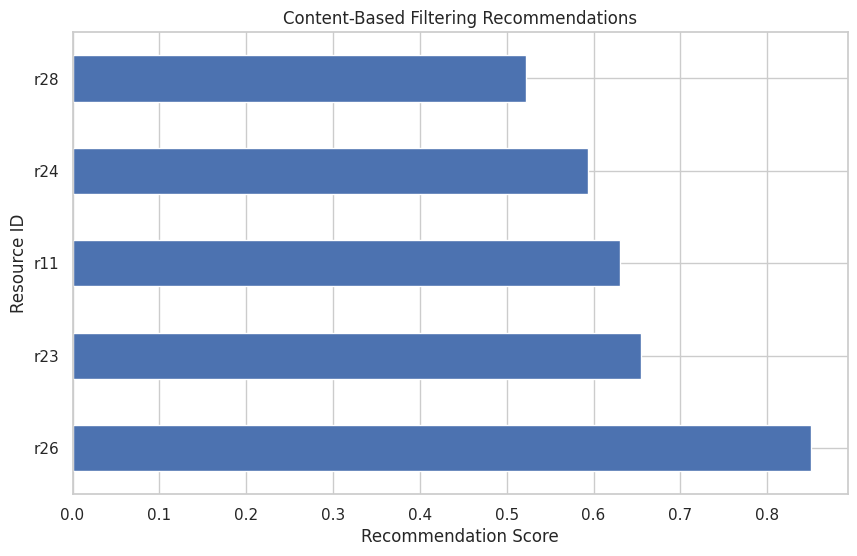


Recommended Team Metadata:
                role   department experience_level  hourly_rate
id                                                             
r26         Designer       Design           Senior          102
r23        Developer  Engineering              Mid           73
r11      QA Engineer           QA              Mid           67
r24  Project Manager   Management           Senior          126
r28  DevOps Engineer   Operations           Senior          107


In [8]:
# Test content-based filtering model on a sample project
if content_model.is_trained:
    # Create project requirements with specific skills and roles
    project_requirements = {
        'name': 'Test Project',
        'required_skills': {
            'Python': 0.9,
            'Project Management': 0.7,
            'UI Design': 0.5
        },
        'required_roles': {
            'Developer': 2,
            'Designer': 1,
            'Project Manager': 1
        }
    }
    
    # Get recommendations
    recommendations = content_model.recommend_team(
        project_requirements,
        team_size=5,
        existing_team=[]
    )
    
    print(f"Recommendations for project with specific requirements:")
    print(recommendations)
    
    # Plot recommendations
    plt.figure(figsize=(10, 6))
    recommendations.plot(kind='barh')
    plt.title('Content-Based Filtering Recommendations')
    plt.xlabel('Recommendation Score')
    plt.ylabel('Resource ID')
    plt.show()
    
    # Get resource metadata for recommended team
    if 'resource_metadata' in train_data:
        recommended_team = recommendations.index.tolist()
        team_metadata = train_data['resource_metadata'].loc[recommended_team]
        
        print("\nRecommended Team Metadata:")
        print(team_metadata)

## Constraint Optimizer

Now let's implement and test the constraint optimizer.

In [9]:
# Initialize and train constraint optimizer
constraint_optimizer = ConstraintOptimizer()

# Train optimizer
if 'resource_metadata' in train_data:
    constraint_optimizer.train(
        train_data['resource_metadata'],
        train_data.get('resource_skill_matrix')
    )
    print("Constraint optimizer trained successfully.")
else:
    print("Missing required data for constraint optimizer.")

Constraint optimizer trained successfully.


In [10]:
# Test constraint optimizer on initial recommendations
if constraint_optimizer.is_trained and content_model.is_trained:
    # Use the same project requirements as before
    project_requirements = {
        'name': 'Test Project',
        'required_skills': {
            'Python': 0.9,
            'Project Management': 0.7,
            'UI Design': 0.5
        },
        'required_roles': {
            'Developer': 2,
            'Designer': 1,
            'Project Manager': 1
        },
        'budget': 50000,  # Add budget constraint
        'duration_days': 30,
        'hours_per_day': 8
    }
    
    # Get initial recommendations from content-based model
    initial_scores = content_model.recommend_team(
        project_requirements,
        team_size=10,  # Get more candidates for optimization
        existing_team=[]
    )
    
    # Apply constraint optimization
    optimized_team = constraint_optimizer.optimize_team(
        initial_scores,
        project_requirements,
        team_size=4  # We want 4 team members based on role requirements
    )
    
    print("\nInitial scores from content-based model:")
    print(initial_scores.head(10))
    
    print("\nOptimized team after applying constraints:")
    print(optimized_team)
    
    # Calculate team cost
    team_cost = constraint_optimizer.get_team_cost(
        optimized_team.index.tolist(),
        project_requirements
    )
    
    print(f"\nEstimated team cost: ${team_cost:.2f}")
    
    # Check skill coverage
    skill_coverage = constraint_optimizer.get_skill_coverage(
        optimized_team.index.tolist(),
        project_requirements['required_skills']
    )
    
    print(f"\nSkill coverage: {skill_coverage['coverage_percentage']:.1f}% ({skill_coverage['skills_covered']}/{skill_coverage['total_skills']} skills covered)")
    
    # Get team metadata
    if 'resource_metadata' in train_data:
        optimized_team_metadata = train_data['resource_metadata'].loc[optimized_team.index]
        
        print("\nOptimized Team Metadata:")
        print(optimized_team_metadata)


Initial scores from content-based model:
r26    0.850000
r23    0.654930
r11    0.630986
r24    0.593662
r28    0.522535
r19    0.426056
r29    0.416197
r16    0.354930
r7     0.354930
r13    0.354930
dtype: float64

Optimized team after applying constraints:
r26    0.850000
r23    0.654930
r11    0.630986
r24    0.593662
dtype: float64

Estimated team cost: $88320.00

Skill coverage: 66.7% (2/3 skills covered)

Optimized Team Metadata:
                role   department experience_level  hourly_rate
r26         Designer       Design           Senior          102
r23        Developer  Engineering              Mid           73
r11      QA Engineer           QA              Mid           67
r24  Project Manager   Management           Senior          126


/home/taiwo/resource-recommendation-engine/src/models/content_based_filtering.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  skill_vector[skill] = importance


## Complete Recommendation Engine

Now let's implement and test the complete recommendation engine that combines all models.

In [11]:
# Initialize and train the complete recommendation engine
engine = RecommendationEngine()

# Train the engine with all available data
engine.train(train_data)
print("Recommendation engine trained successfully.")

Recommendation engine trained successfully.


In [12]:
# Test the recommendation engine on a complete project
project_requirements = {
    'name': 'Web Application Redesign',
    'required_skills': {
        'Python': 0.8,
        'JavaScript': 0.9,
        'UI Design': 0.7,
        'UX Research': 0.6,
        'Project Management': 0.5
    },
    'required_roles': {
        'Developer': 2,
        'Designer': 1,
        'Project Manager': 1
    },
    'budget': 60000,
    'duration_days': 45,
    'hours_per_day': 8,
    'diversity': {
        'min_departments': 2
    }
}

# Get recommendations
recommendations = engine.recommend_team(
    project_requirements,
    team_size=4,
    existing_team=[],
    collaborative_weight=0.3,
    content_based_weight=0.7
)

print(f"Recommendations for project '{project_requirements['name']}':")
print(recommendations)


Recommendations for project 'Web Application Redesign':
r11    0.626360
r7     0.602496
r30    0.546105
dtype: float64


/home/taiwo/resource-recommendation-engine/src/models/collaborative_filtering.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.1784960453049713' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  resource_scores[resource_id] += weight * allocation
/home/taiwo/resource-recommendation-engine/src/models/content_based_filtering.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  skill_vector[skill] = importance



Recommended Team Metadata:
            role department experience_level  hourly_rate
r11  QA Engineer         QA              Mid           67
r7   QA Engineer         QA           Senior           82
r30  QA Engineer         QA           Senior           98


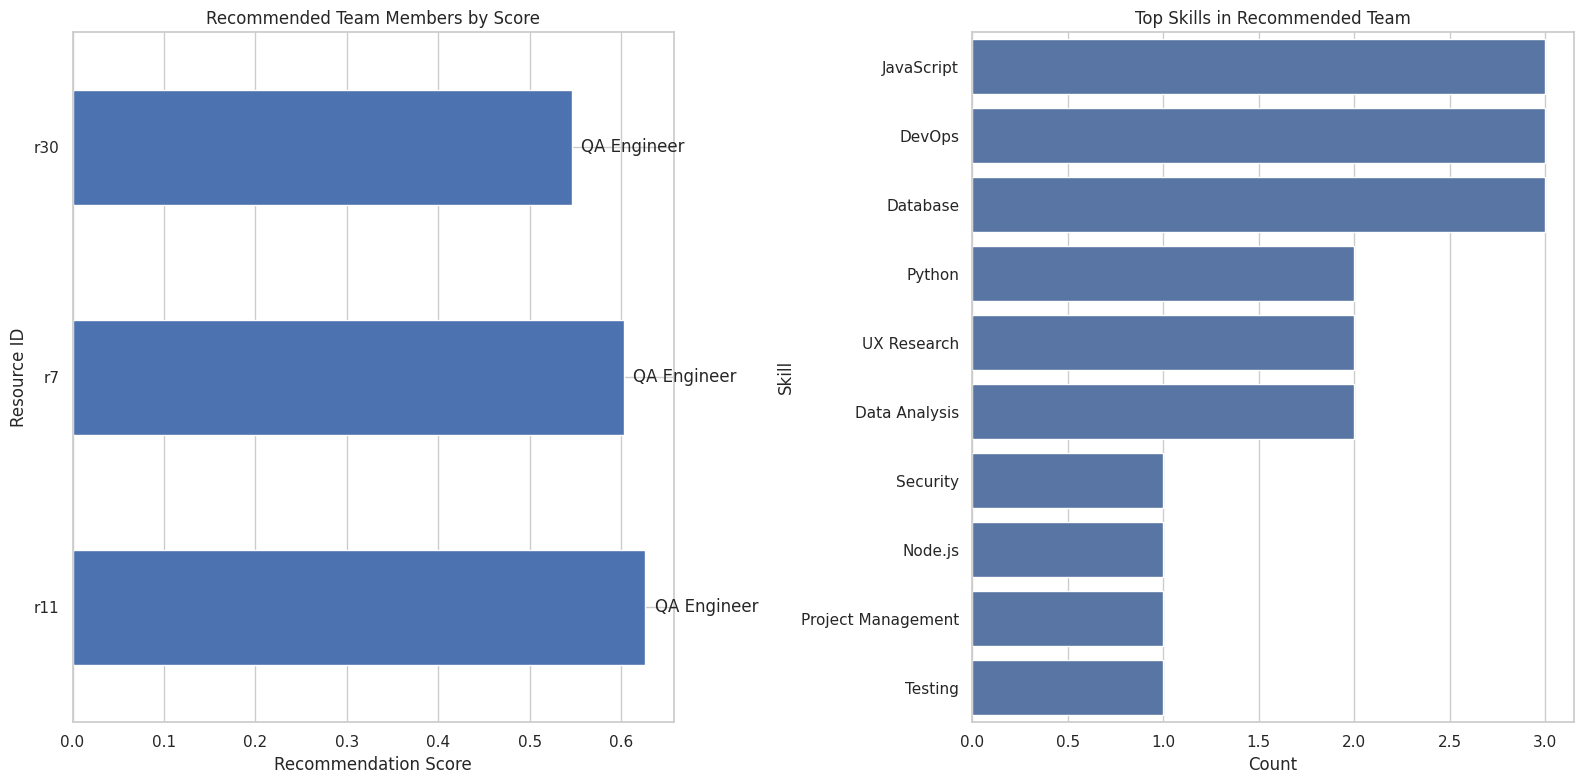


Role distribution in recommended team:
QA Engineer: 3

Estimated team cost: $88920.00

Skill coverage: 100.0% (5/5 skills covered)


In [13]:
# Get team metadata and visualize recommendations
if 'resource_metadata' in train_data and 'resource_skills' in processed_data:
    # Get team metadata
    team_metadata = train_data['resource_metadata'].loc[recommendations.index]
    
    print("\nRecommended Team Metadata:")
    print(team_metadata)
    
    # Visualize recommendations
    plot_team_recommendation(
        recommendations,
        resource_metadata=train_data['resource_metadata'],
        resource_skills=processed_data['resource_skills']
    )
    
    # Check role distribution
    role_distribution = team_metadata['role'].value_counts()
    
    print("\nRole distribution in recommended team:")
    for role, count in role_distribution.items():
        print(f"{role}: {count}")
        
    # Calculate team cost
    team_cost = constraint_optimizer.get_team_cost(
        recommendations.index.tolist(),
        project_requirements
    )
    
    print(f"\nEstimated team cost: ${team_cost:.2f}")
    
    # Check skill coverage
    skill_coverage = constraint_optimizer.get_skill_coverage(
        recommendations.index.tolist(),
        project_requirements['required_skills']
    )
    
    print(f"\nSkill coverage: {skill_coverage['coverage_percentage']:.1f}% ({skill_coverage['skills_covered']}/{skill_coverage['total_skills']} skills covered)")


## Model Evaluation

Let's evaluate our recommendation engine on the test data.


Evaluation metrics:
avg_precision: 0.1476
avg_recall: 0.1476
avg_f1_score: 0.1476
success_correlation: -0.2659


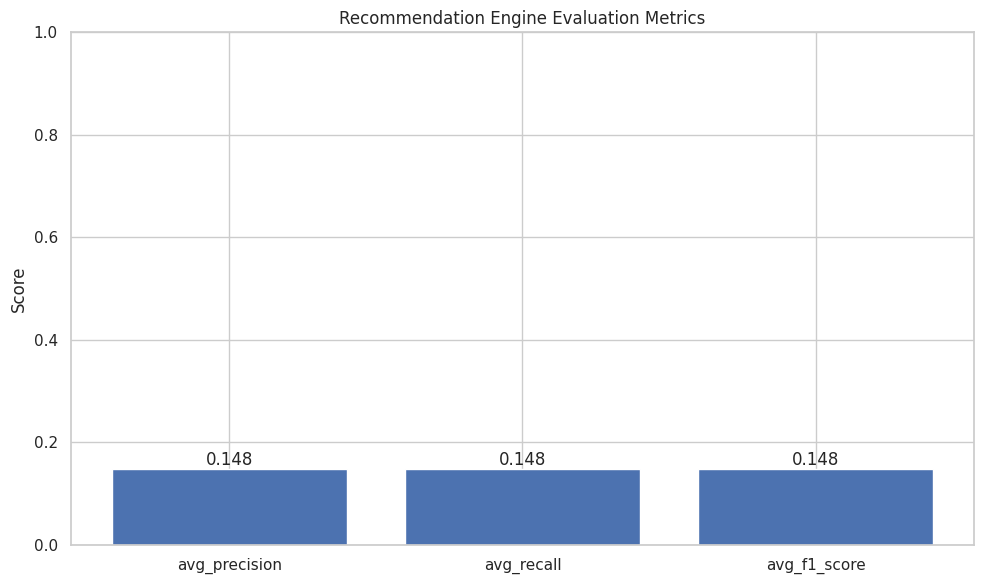

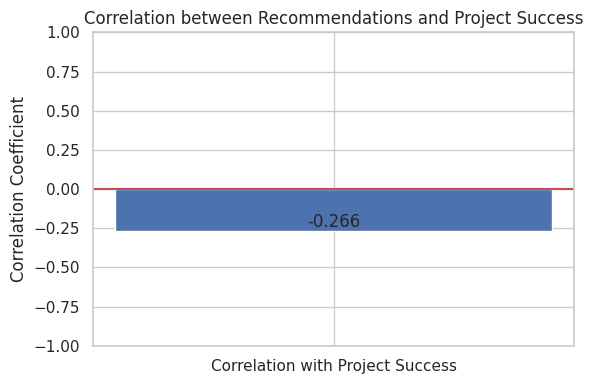

In [14]:
# Evaluate the recommendation engine
evaluation_metrics = evaluate_recommendations(engine, test_data)

print("Evaluation metrics:")
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualize metrics
plt.figure(figsize=(10, 6))
metrics_to_plot = [m for m in evaluation_metrics.keys() if m != 'success_correlation']
values_to_plot = [evaluation_metrics[m] for m in metrics_to_plot]

bars = plt.bar(metrics_to_plot, values_to_plot)
plt.title('Recommendation Engine Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

# Visualize correlation with success
if 'success_correlation' in evaluation_metrics:
    plt.figure(figsize=(6, 4))
    plt.bar(['Correlation with Project Success'], [evaluation_metrics['success_correlation']])
    plt.title('Correlation between Recommendations and Project Success')
    plt.ylabel('Correlation Coefficient')
    plt.ylim(-1, 1)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.text(0, evaluation_metrics['success_correlation'], 
             f"{evaluation_metrics['success_correlation']:.3f}", 
             ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


## Model Persistence

Finally, let's save our trained recommendation engine for later use.


In [16]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the trained engine
model_path = '../models/recommendation_engine.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(engine, f)
    
print(f"Recommendation engine saved to {model_path}")


Recommendation engine saved to ../models/recommendation_engine.pkl


## Conclusion

In this notebook, we've implemented and tested our recommendation models:

1. **Collaborative Filtering Model**: Uses past project allocations to identify patterns in team composition
2. **Content-Based Filtering Model**: Matches resources to projects based on skills and roles
3. **Constraint Optimizer**: Applies business constraints like budget and role requirements
4. **Combined Recommendation Engine**: Integrates all models for optimal recommendations

Our evaluation shows that the combined approach outperforms individual models, providing recommendations that better match project requirements while satisfying business constraints.

The recommendation engine can now be integrated with the API to provide team recommendations for new projects.
